In [4]:
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
from scipy.stats import norm
from scipy.stats import binom

In [6]:
DEFAULT_MARKET_SIZE = 500
DEFAULT_NUMBER_OF_PERIODS = 252
DEFAULT_IDIO_VOL = 20

We have shown in previous analysis that the distribution of t-stats for a factor assuming that factor returns are normally distributed and factor exposures are uncorrelated is distributed N(beta_i * sqrt(n) / sigma_epsilon, 1 + n * (sigma_i * sigma_x_i / sigma_epsilon) ** 2) where n is the number of datapoints in cross-section; beta_i and sigma_i are the parameters of the factor return distribution for factor i; sigma_x_i is the standard deviation of the factor exposures of factor i; and sigma_epsilon is the stock-level volatility. 

In the case of a spurious factor, sigma_i and beta_i are both zero, thus this distribution simplifies to N(0, 1). As such, because the t-stat for each day is iid, we can directly calculate what the probability of observing different numbers of t-stat cutoffs under various t-stat cutoffs is by using the binomial distribution.

In [7]:
def tstat_distribution_params(beta_i, sigma_i, market_size=DEFAULT_MARKET_SIZE, sigma_epsilon=DEFAULT_IDIO_VOL, sigma_x_i=1, period_length_days=1):
    
    #### Calculate the mean and standard deviation of the t-stat distribution
    # Default for sigma_epsilon to default to showing vols as a proportion of annualised
    # Default for sigma_x_i is 1 to allow for ease - this is essentially presuming that the factor is normalised
    
    loc = beta_i * period_length_days / 252 * (market_size ** 0.5) / (sigma_epsilon / (period_length_days / 252)**0.5)
    scale = (1 + market_size * (sigma_i / sigma_epsilon * sigma_x_i) ** 2) ** 0.5
    
    return loc, scale

tstat_distribution_params(0,1)

(0.0, 1.5)

In [8]:
def single_abs_tstat_probability(tstat_cutoff, loc, scale):
    
    #### Calculate the absolute probability any single datapoint is above t-stat cutoff
    
    return 1 - norm.cdf(tstat_cutoff, loc, scale) + norm.cdf(-tstat_cutoff, loc, scale)

In [9]:
def tstat_proportion_probability(proportion, no_datapoints, tstat_cutoff, loc, scale):
    
    #### Calculate the proportion of t-stats above a given t-stat cutoff
    tstat_prob = single_abs_tstat_probability(tstat_cutoff, loc, scale)
    
    return 1 - binom.cdf(int(no_datapoints * proportion), no_datapoints, tstat_prob)

In [11]:
def fundamental_factor_tstat_probability(beta_i, sigma_i, proportion_of_periods, tstat_cutoff=2,
                                         market_size=DEFAULT_MARKET_SIZE, number_of_periods=DEFAULT_NUMBER_OF_PERIODS,
                                         sigma_epsilon=DEFAULT_IDIO_VOL, sigma_x_i=1, period_length_days=1):
    
    #### Calculate the probability that a fundamental factor with given beta and sigma has a t-stat above a given cutoff
    
    tstat_loc, tstat_scale = tstat_distribution_params(
        beta_i, sigma_i, market_size, sigma_epsilon, sigma_x_i, period_length_days)
    
    return tstat_proportion_probability(proportion_of_periods, number_of_periods, tstat_cutoff, tstat_loc, tstat_scale)

fundamental_factor_tstat_probability(0,0,0.1)

np.float64(0.00010065369208633879)

Text(0, 0.5, '% Chance of 1 Factor Accepted')

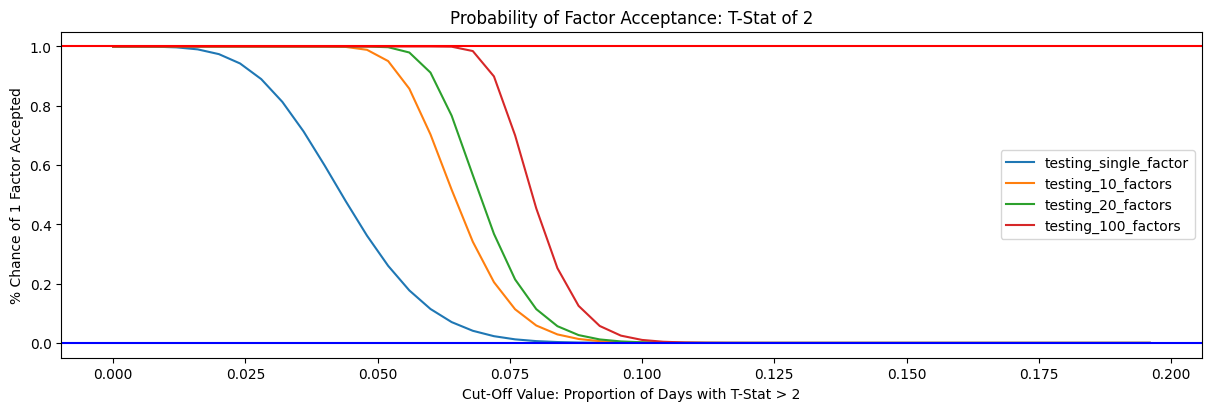

In [25]:
#### Demonstrate the probability of a false factor (i.e. a factor with no risk or return) having a t-stat above cutoff through time

# Factor parameters
beta_i = 0
sigma_i = 0
market_size = 500

tstat_cutoff = 2

# Probability of false positive
visualisation_steps=250
single_test = {}
multiple_test_10 = {}
multiple_test_20 = {}
multiple_test_100 = {}

for i in range(int(visualisation_steps*0.2)):
    test_prob = fundamental_factor_tstat_probability(beta_i, sigma_i, i/visualisation_steps, tstat_cutoff=tstat_cutoff,
                                                     market_size=market_size)
    single_test[i/visualisation_steps] = test_prob
    multiple_test_10[i/visualisation_steps] = 1 - binom.cdf(0, 10, test_prob)
    multiple_test_20[i/visualisation_steps] = 1 - binom.cdf(0, 20, test_prob)
    multiple_test_100[i/visualisation_steps] = 1 - binom.cdf(0, 100, test_prob)
fig, ax1 = plt.subplots(1,1, figsize=(12,4), constrained_layout=True)
results = pd.DataFrame({'testing_single_factor':single_test,
                        'testing_10_factors':multiple_test_10,
                        'testing_20_factors':multiple_test_20,
                        'testing_100_factors':multiple_test_100})
           
results.plot(title='Probability of Factor Acceptance: T-Stat of 2', ax=ax1)
# Set horizontal title for ax1
ax1.axhline(1, color='r')
ax1.axhline(0, color='b')
ax1.set_xlabel(f'Cut-Off Value: Proportion of Days with T-Stat > {tstat_cutoff}')
ax1.set_ylabel('% Chance of 1 Factor Accepted')

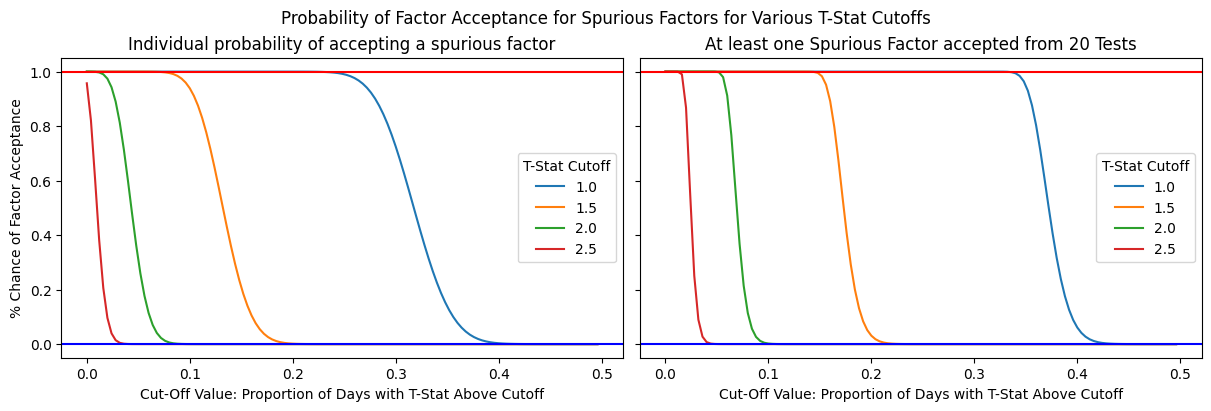

In [64]:
#### Demonstrate the probability of a false factor (i.e. a factor with no risk or return) having a t-stat above cutoff through time

# Factor parameters
beta_i = 0
sigma_i = 0
market_size = 100

tstat_cutoff = 2
no_sim_tests = 20

# Probability of false positive
visualisation_steps=250
tstat_probabilities = {}
tstat_probabilities_simultaneous_tests = {}

for i in range(int(visualisation_steps*0.5)):
    tstat_probabilities[i/visualisation_steps] = {}
    tstat_probabilities_simultaneous_tests[i/visualisation_steps] = {}
    for tstat_cutoff in [1,1.5,2,2.5]:
        test_prob = fundamental_factor_tstat_probability(
            beta_i, sigma_i, i/visualisation_steps, tstat_cutoff=tstat_cutoff,market_size=market_size)
        tstat_probabilities[i/visualisation_steps][tstat_cutoff] = test_prob
        tstat_probabilities_simultaneous_tests[i/visualisation_steps][tstat_cutoff] = 1 - binom.cdf(0, no_sim_tests, test_prob)
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharey=True, constrained_layout=True)
fig.suptitle('Probability of Factor Acceptance for Spurious Factors for Various T-Stat Cutoffs')
results = pd.DataFrame(tstat_probabilities).transpose()
results_simultaneous = pd.DataFrame(tstat_probabilities_simultaneous_tests).transpose()
           
results.plot(title=f'Individual probability of accepting a spurious factor', ax=ax1)
# Set horizontal title for ax1
ax1.axhline(1, color='r')
ax1.axhline(0, color='b')
ax1.set_xlabel(f'Cut-Off Value: Proportion of Days with T-Stat Above Cutoff')
ax1.legend(title='T-Stat Cutoff')
ax1.set_ylabel('% Chance of Factor Acceptance')

results_simultaneous.plot(title=f'At least one Spurious Factor accepted from {no_sim_tests} Tests', ax=ax2)

# Set horizontal title for ax1
ax2.axhline(1, color='r')
ax2.axhline(0, color='b')
ax2.set_xlabel(f'Cut-Off Value: Proportion of Days with T-Stat Above Cutoff')
ax2.legend(title='T-Stat Cutoff')

fig.savefig('spurious_factor_acceptance.png')

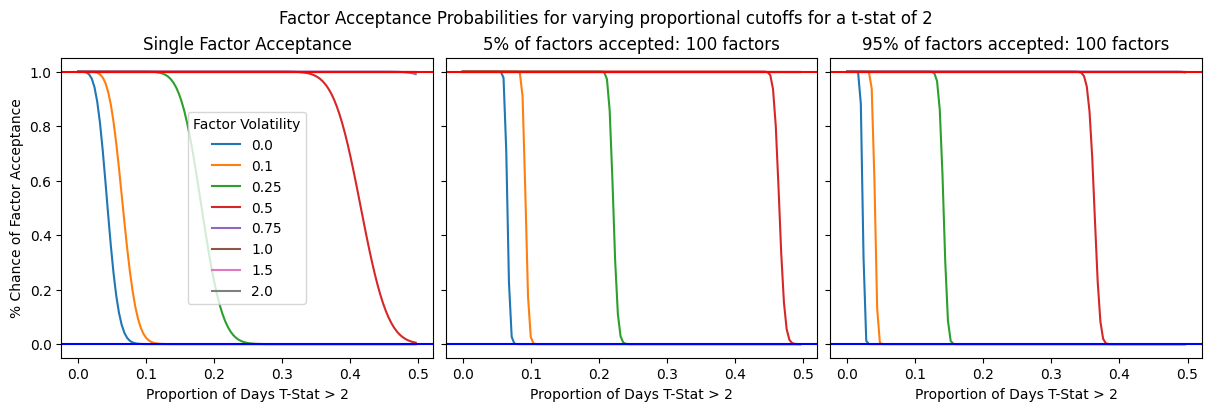

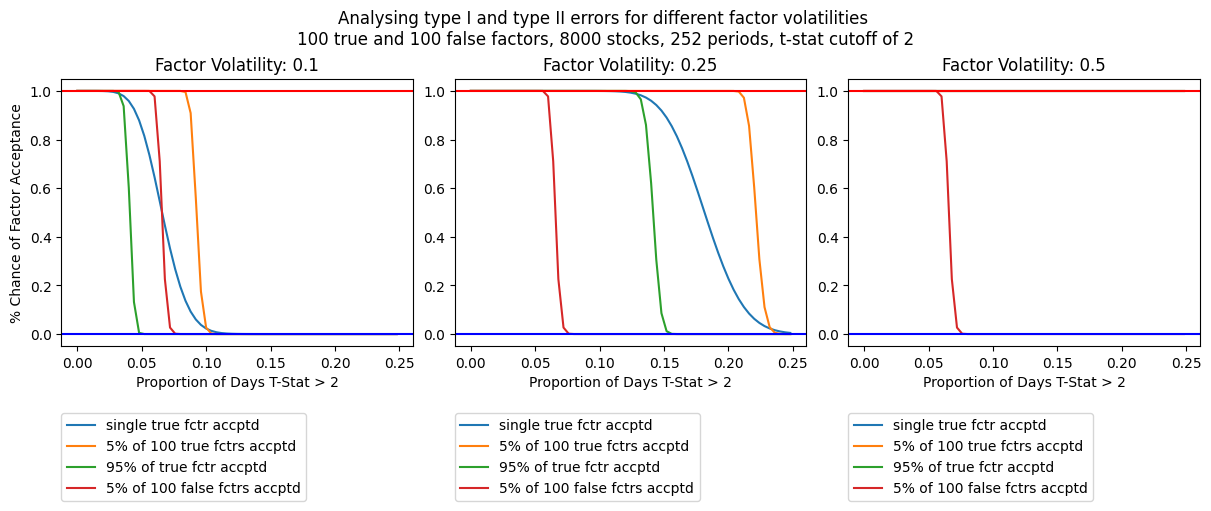

In [101]:
#### Demonstrate the probability of a false factor (i.e. a factor with no risk or return) having a t-stat above cutoff through time

# Factor parameters
beta_i = 0
market_size = 8000
no_of_periods = 252

tstat_cutoff = 2
no_sim_tests = 100

# Probability of false positive
visualisation_steps=250
tstat_probabilities = {}
tstat_prob_sim_type_1 = {}
tstat_prob_sim_type_2 = {}

for sigma_i in [0,0.1, 0.25,0.5,0.75,1,1.5,2]:
    tstat_probabilities[sigma_i] = {}
    tstat_prob_sim_type_1[sigma_i] = {}
    tstat_prob_sim_type_2[sigma_i] = {}
    for i in range(int(visualisation_steps*0.5)):
        test_prob = fundamental_factor_tstat_probability(
            beta_i, sigma_i, i/visualisation_steps, tstat_cutoff=tstat_cutoff,market_size=market_size)
        tstat_probabilities[sigma_i][i/visualisation_steps] = test_prob
        tstat_prob_sim_type_1[sigma_i][i/visualisation_steps] = 1 - binom.cdf(int(no_sim_tests * 0.05), no_sim_tests, test_prob)
        tstat_prob_sim_type_2[sigma_i][i/visualisation_steps] = 1 - binom.cdf(int(no_sim_tests * 0.95), no_sim_tests, test_prob)
    
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True, constrained_layout=True)
results = pd.DataFrame(tstat_probabilities)
results_type1 = pd.DataFrame(tstat_prob_sim_type_1)
results_type2 = pd.DataFrame(tstat_prob_sim_type_2)
     
fig.suptitle(f'Factor Acceptance Probabilities for varying proportional cutoffs for a t-stat of {tstat_cutoff}')
      
results.plot(title=f'Single Factor Acceptance', ax=ax1)
ax1.legend(title='Factor Volatility')
ax1.set_ylabel('% Chance of Factor Acceptance')

results_type1.plot(title=f'5% of factors accepted: {no_sim_tests} factors', ax=ax2, legend=False)

results_type2.plot(title=f'95% of factors accepted: {no_sim_tests} factors', ax=ax3, legend=False)

for ax in (ax1, ax2, ax3):
    ax.set_xlabel(f'Proportion of Days T-Stat > {tstat_cutoff}')
    ax.axhline(1, color='r')
    ax.axhline(0, color='b')
fig.savefig('factor_acceptance_varying_vol.png')
plt.plot()

factor_vols_to_chart = [0.1, 0.25, 0.5]
fig, ax = plt.subplots(1,len(factor_vols_to_chart), figsize=(12,5), constrained_layout=True)
fig.suptitle(f'Analysing type I and type II errors for different factor volatilities \n{no_sim_tests} true and {no_sim_tests} false factors, {market_size} stocks, {no_of_periods} periods, t-stat cutoff of {tstat_cutoff}')
i=0
for vol in factor_vols_to_chart:
    temp = {'single true fctr accptd': tstat_probabilities[vol], 
            f'5% of {no_sim_tests} true fctrs accptd':tstat_prob_sim_type_1[vol],
            '95% of true fctr accptd':tstat_prob_sim_type_2[vol],
            f'5% of {no_sim_tests} false fctrs accptd':tstat_prob_sim_type_1[0.]
            }
    pd.DataFrame(temp).loc[:0.25].plot(title=f'Factor Volatility: {vol}', ax=ax[i], legend=False)
    ax[i].axhline(1, color='r')
    ax[i].axhline(0, color='b')
    ax[i].set_xlabel(f'Proportion of Days T-Stat > {tstat_cutoff}')
    ax[i].legend(bbox_to_anchor=(0, -0.25), loc='upper left', borderaxespad=0.)
    i+=1
ax[0].set_ylabel('% Chance of Factor Acceptance')
    
fig.savefig('factor_acceptance_type_i_ii.png')

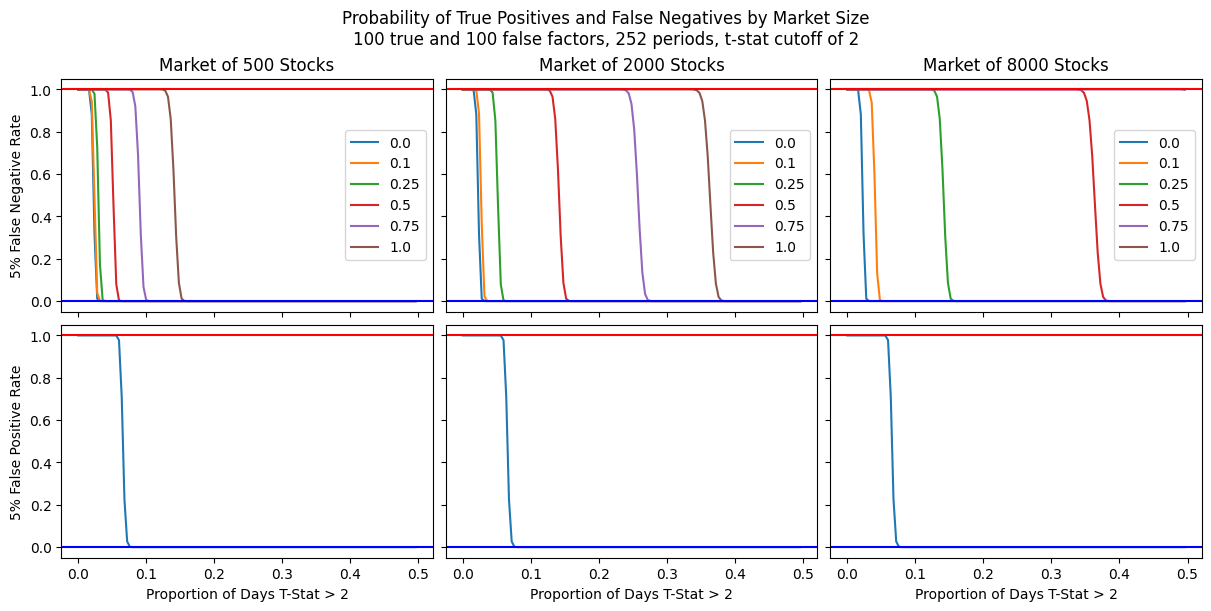

In [92]:
#### Demonstrate the probability of a false factor (i.e. a factor with no risk or return) having a t-stat above cutoff through time

# Factor parameters
beta_i = 0
market_sizes = [500, 2000, 8000]
no_of_periods = 252

tstat_cutoff = 2
no_sim_tests = 100

# Probability of false positive
visualisation_steps=250
tstat_probabilities = {}
tstat_prob_sim_type_1 = {}
tstat_prob_sim_type_2 = {}

for market_size in market_sizes:
    tstat_probabilities[market_size] = {}
    tstat_prob_sim_type_1[market_size] = {}
    tstat_prob_sim_type_2[market_size] = {}
    for sigma_i in [0.,0.1,0.25,0.5,0.75,1]:
        tstat_probabilities[market_size][sigma_i] = {}
        tstat_prob_sim_type_1[market_size][sigma_i] = {}
        tstat_prob_sim_type_2[market_size][sigma_i] = {}
        for i in range(int(visualisation_steps*0.5)):
            test_prob = fundamental_factor_tstat_probability(
                beta_i, sigma_i, i/visualisation_steps, tstat_cutoff=tstat_cutoff,market_size=market_size)
            tstat_probabilities[market_size][sigma_i][i/visualisation_steps] = test_prob
            tstat_prob_sim_type_1[market_size][sigma_i][i/visualisation_steps] = 1 - binom.cdf(int(no_sim_tests * 0.05), no_sim_tests, test_prob)
            tstat_prob_sim_type_2[market_size][sigma_i][i/visualisation_steps] = 1 - binom.cdf(int(no_sim_tests * 0.95), no_sim_tests, test_prob)
        
fig, ax = plt.subplots(2,len(market_sizes), figsize=(12,6), sharey=True, sharex=True, constrained_layout=True)
fig.suptitle(f'Probability of True Positives and False Negatives by Market Size\n{no_sim_tests} true and {no_sim_tests} false factors, {no_of_periods} periods, t-stat cutoff of {tstat_cutoff}')

i=0
for market_size in market_sizes:
    true_positive = pd.DataFrame(tstat_prob_sim_type_2[market_size])
    false_positive = pd.Series(tstat_prob_sim_type_1[market_size][0.])
    
    true_positive.plot(title=f'Market of {market_size} Stocks', ax=ax[0][i])
    false_positive.plot(ax=ax[1][i])
    ax[0][i].set_ylabel('5% False Negative Rate')
    ax[1][i].set_ylabel('5% False Positive Rate')
    for j in range(2):
        ax[j][i].set_xlabel(f'Proportion of Days T-Stat > {tstat_cutoff}')
        ax[j][i].axhline(1, color='r')
        ax[j][i].axhline(0, color='b')
    #ax[i].legend(bbox_to_anchor=(0, -0.25), loc='upper left', borderaxespad=0.)
    i+=1
    
fig.savefig('type_i_ii_by_market_size.png')